# Setup and Obtain the Data 
## Import Libraries and Dependencies

In [ ]:
%pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations pillow

## Collect Images Using OpenCV

In [95]:
import os  # for accessing the file system
import time  # for measuring the inference time per image
import uuid  # for generating unique IDs for our images
import cv2  # for computer vision tasks

In [96]:
IMAGES_PATH = os.path.join('Tensorflow', 'images')
number_of_images = 100

In [ ]:
# Collecting Images and name them with our unique IDs
capture = cv2.VideoCapture(0)
for i in range(number_of_images):
    ret, frame = capture.read()
    # Generate a unique ID for our image
    img_id = uuid.uuid1()
    img_name = os.path.join(IMAGES_PATH, f'image_{img_id}.jpg')
    # Save the image
    cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    print(f'Image {i} saved')
# Release the camera resource and desstroy the window opened by OpenCV
capture.release()
cv2.destroyAllWindows()

## Annotating Images with Bounding Boxes in LabelMe

In [ ]:
!labelme

# Reviewing Dataset and Building our Image Pipeline and Loading Function
## Importing TensorFlow and Other Dependencies

In [98]:
import tensorflow as tf
import json  # for reading our labelme JSON files
import numpy as np  # for data manipulation
from matplotlib import pyplot as plt # for visualization

## Limit GPU Memory Growth

In [ ]:
# Avoiding Tensorflow warnings and out of memory errors by limiting the GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# Checking if Tensorflow is using the GPU
tf.config.list_physical_devices('GPU')

## Loading Image into the TensorFlow Dataset

In [ ]:
# Loading the images from the disk and set shuffle to False to keep the images in order
images = tf.data.Dataset.list_files('Tensorflow/images/*.jpg', shuffle=False)

In [ ]:
images.as_numpy_iterator().next()

In [102]:
def load_image(image_path):
    # Reading the image from the disk
    image = tf.io.read_file(image_path)
    # Decoding the image to a Tensor
    image = tf.image.decode_jpeg(image)
    return image

In [ ]:
# Mapping the load_image function to all the items in the dataset
images = images.map(load_image)

In [ ]:
# Visualizing the first image
images.as_numpy_iterator().next()

## Visualizing the Dataset with Matplotlib

In [105]:
# View raw image
image_generator = images.batch(4).as_numpy_iterator

In [ ]:
plot_images = image_generator().next()

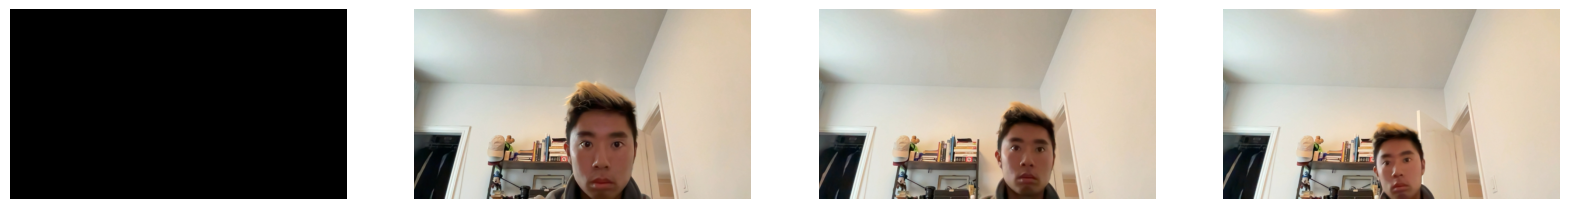

In [109]:
# Plotting the images in a row with matplotlib in a 1x4 grid
fig, axes = plt.subplots(ncols = 4, figsize=(20, 20))
for i, image in enumerate(plot_images):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()

# Partitioning the Unaugmented Dataset into Training and Validation Sets
## Splitting the Dataset into Training and Validation Sets

In [108]:
# Objective: To create a dataset of images and their corresponding bounding boxes
# Create 3 folders for our dataset: train, test, and val
# Create 2 folders inside each folder: labels and images

# Split the dataset into train, test, and val sets
# 60% for training, 20% for testing, and 20% for validation
# We have 100 images, so 60 images for training, 20 images for testing, and 20 images for validation
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('Tensorflow', folder, 'images')):

        # Get the image ID from the file name
        filename = file.split('.')[0]+'.json'
        existing_file_path = os.path.join('Tensorflow', 'labels', filename)
        # Check if the file exists in the labels folder and move it to the corresponding folder
        if os.path.exists(existing_file_path):
            new_filepath = os.path.join('Tensorflow', folder, 'labels', filename)
            os.replace(existing_file_path, new_filepath)

# Application of Data Augmentation on Images and Labels Using the Albumentations Library
## Importing the Albumentations Library and Defining the Augmentation Pipeline

In [110]:
import albumentations as alb

In [234]:
# Define the augmentation pipeline from example on the Albumentations documentation
# https://albumentations.ai/docs/examples/example_bboxes/
# Performs random crop, horizontal flip, random brightness/contrast, random gamma, RGB shift, blur, and vertical flip
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## Load a test image and visualize the results of the augmentation pipeline

In [212]:
# Pass an image from our traaining data set to the augmentation pipeline
test_img = cv2.imread(os.path.join('Tensorflow', 'train', 'images', 'image_151f9022-5a47-11ee-89af-8eb28c7fe3a8.jpg'))
# Load the corresponding JSON file
with open(os.path.join('Tensorflow', 'train', 'labels', 'image_151f9022-5a47-11ee-89af-8eb28c7fe3a8.json')) as f:
    label = json.load(f)

In [ ]:
label['shapes'][0]['points']

## Extracting the Bounding Boxes from the Augmented Images and then Resize the Images to Match the Input Size of the Model

In [249]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [252]:
# View the normalized 
# Why are the coordinates changing after each run?
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.0023778417088963963,
 0.00033392767767767806,
 0.0031696491413288294,
 0.0022225350350350355]

## Apply Augmentation and View Results

In [258]:
augmented = augmentor(image=test_img, bboxes=[coords], class_labels=['face'])
augmented['bboxes']

In [239]:
# Draw the bounding box on our augmented image by extrapolating the coordinates
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][0:2], [450, 450]).astype(int)),
                tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
                (255, 0, 0), 2)

# # View the augmented image on the notebook
plt.imshow(augmented['image'])

{'image': array([[[  7,   4,   2],
         [  8,   4,   2],
         [  9,   6,   2],
         ...,
         [150, 192, 225],
         [152, 190, 227],
         [153, 192, 230]],
 
        [[  7,   4,   1],
         [  8,   5,   2],
         [  9,   6,   2],
         ...,
         [151, 193, 226],
         [151, 193, 226],
         [151, 193, 228]],
 
        [[  7,   4,   1],
         [  8,   5,   2],
         [  8,   5,   2],
         ...,
         [151, 193, 226],
         [152, 194, 227],
         [150, 192, 225]],
 
        ...,
 
        [[202, 204, 190],
         [202, 204, 190],
         [202, 204, 190],
         ...,
         [175, 186, 186],
         [176, 187, 187],
         [176, 187, 187]],
 
        [[202, 204, 190],
         [202, 204, 190],
         [202, 204, 190],
         ...,
         [175, 186, 186],
         [176, 187, 187],
         [176, 187, 187]],
 
        [[202, 204, 190],
         [202, 204, 190],
         [202, 204, 190],
         ...,
         [176, 187,